aws s3 cp --recursive ./models s3://sagemaker.us-east-1.mi-crs-chatrd-dev/tmp/s3_bucket

# Run Config

In [1]:
# !pip install transformers==4.48.3
# !pip install accelerate
# !pip install bitsandbytes
# !pip install sentencepiece
# !pip install protobuf
# !pip install sentence-transformers==3.4.1
# !pip install peft datasets altair pandas matplotlib tabulate

In [2]:
# !pip install --upgrade accelerate transformers sentence-transformers datasets
# !pip install --upgrade torch torchvision torchaudio

In [3]:
RUN_NAME = "ROUTING_CRITERIA_UC_TYPE2_"
RUN_DESCRIPTION = """
Routing changes Key Revenue Drivers
"""
RESULTS_DIR = "./models"
 
MODEL_HF_NAME = "nomic-ai/modernbert-embed-base"
MODEL_EPOCH = 5
MODEL_BATCH_SIZE = 128
MODEL_BONE_R = 16
 
CLASSIFIER_TYPE = 'knn'
TRUNCATION = 64
 
KMEANS_N_CLUSTERS = 500
KNN_CLASSIFIER_ARGS = {
    'n_neighbors' : 1
}
 

# Imports

In [4]:
import json
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, losses
from torch.utils.data import DataLoader
from sentence_transformers.readers import InputExample
import os
import re
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, losses, SentenceTransformerTrainingArguments
from sentence_transformers.util import euclidean_sim
from pathlib import Path
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# from cuml.cluster import KMeans
import numpy as np
from scipy.stats import mode
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, BisectingKMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.preprocessing import LabelEncoder
# from cuml.cluster import KMeans
# from cuml import UMAP
import sklearn
from torch.nn import functional as F
import torch
from scipy.stats import mode
from sklearn.neighbors import KNeighborsClassifier
import altair as alt
import pandas as pd
from IPython.display import Markdown
from peft import LoraConfig, TaskType, BoneConfig
from sentence_transformers import SentenceTransformer
alt.data_transformers.enable("vegafusion")

/home/sagemaker-user/.conda/envs/routing/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DataTransformerRegistry.enable('vegafusion')

## SETUP

In [5]:
RESULTS_PATH = Path(RESULTS_DIR)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)
(RESULTS_PATH / 'adapters').mkdir(parents=True, exist_ok=True)
(RESULTS_PATH / 'classifiers').mkdir(parents=True, exist_ok=True)
RUN_ID = f"{RUN_NAME}_{datetime.datetime.now().strftime('%Y-%m-%d')}"
RUN_ID

'ROUTING_CRITERIA_UC_TYPE2__2025-11-03'

# Create Training Data

In [6]:
def extract_keys(template):
    keys = re.findall(r"{(.*?)}", template)
    return keys


def get_dictionary_from_folders(directory_path: str):
    json_dict = {}

    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):
            file_path = os.path.join(directory_path, filename)

            with open(file_path, "r") as file:
                json_content = json.load(file)

            key = os.path.splitext(filename)[0]

            json_dict[key] = json_content

    return json_dict
    
mappings = get_dictionary_from_folders("/home/sagemaker-user/creditcompanion/scripts/uc_embedding_generation/template_values")
template_values = get_dictionary_from_folders("/home/sagemaker-user/creditcompanion/scripts/uc_embedding_generation/templates")

def generate_questions(mappings, template_values, num_runs, K):
    questions = {}
    n_timer = defaultdict(lambda: 1, {key : K // len(template_values[key]) for key in template_values.keys()})
    for key, values in template_values.items():
        templates = values
        for template in templates:
            unique_questions = set()
            N = num_runs * n_timer[key]
            for _ in range(N):
                present_keys = extract_keys(template)
                all_pairs = {}
                for mp_key in present_keys:
                    all_pairs[mp_key] = random.choice(
                        mappings[mp_key],
                    )
                # print(template)
                question = template.format(**all_pairs)
                unique_questions.add(question)
            if key in questions:
                questions[key].extend(list(unique_questions))
            else:
                questions[key] = list(unique_questions)
    return questions

In [7]:
NUMBER_OF_DATA =max(max([len(template_values[key])+1 for key in template_values]), 500)
questions = generate_questions(mappings, template_values, 1, NUMBER_OF_DATA)
keys = questions.keys()
question_bank = generate_questions(mappings, template_values, 5, NUMBER_OF_DATA)
validation_bank = generate_questions(mappings, template_values, 1, NUMBER_OF_DATA)
full_question_bank = [q for key in keys for q in question_bank[key]]
q_l = [(q, cat) for cat in questions.keys() for q in questions[cat]]
q_v = [(q, cat) for cat in validation_bank.keys() for q in validation_bank[cat]]

In [8]:
for k, v in question_bank.items():
    print(k + ":", len(v))

credit_memo: 1564
criteria: 1153
deals_tranche: 2972
definition: 1090
esg: 2565
financials: 2821
general: 2248
info_coverage: 2768
outlook: 2582
peers: 2316
ratings: 2503
rating_action: 1974
research: 2149
scores&modifiers: 2571
securities: 2067
sNw: 2093
query: 2188


In [9]:
anchors = []
positives = []
negatives = []
keys = questions.keys()
for key1 in keys:
    for key2 in keys:
        if key1 == key2:
            pass
        anchor = questions[key1]
        positive = np.random.choice(question_bank[key1], len(anchor))
        negative = np.random.choice(question_bank[key2], len(anchor))
        anchors.extend(anchor)
        positives.extend(positive)
        negatives.extend(negative)

In [10]:
from datasets import Dataset

dataset = Dataset.from_dict({
    "anchor": anchors,
    "positive": positives,
    "negative" : negatives,
})
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Model Training

## Model Instantiation

In [11]:
model = SentenceTransformer(MODEL_HF_NAME, device='cuda')
peft_config = BoneConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    inference_mode=False,
    r=MODEL_BONE_R,
    target_modules={'Wqkv', 'Wo', 'Wi'}
)
model.add_adapter(peft_config)

In [12]:
args = SentenceTransformerTrainingArguments(
    output_dir="/tmp/mbert",
    num_train_epochs=MODEL_EPOCH,
    per_device_train_batch_size=MODEL_BATCH_SIZE,
    per_device_eval_batch_size=MODEL_BATCH_SIZE,
    warmup_ratio=0.1,
    fp16=False,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=True,  # Set to True if you have a GPU that supports BF16
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    logging_steps=500,
    report_to="none"
)

## Model Training

In [13]:
train_loss = losses.MultipleNegativesRankingLoss(model=model, similarity_fct=euclidean_sim, scale = 2)# mini_batch_size = 128)
mtrain_loss = losses.MatryoshkaLoss(loss = train_loss, model = model, matryoshka_dims=[64, 32, 16])
trainer = SentenceTransformerTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    loss=mtrain_loss,
    args = args
)
trainer.train()

TrainOutput(global_step=4850, training_loss=10.53142734173647, metrics={'train_runtime': 3316.075, 'train_samples_per_second': 187.077, 'train_steps_per_second': 1.463, 'total_flos': 0.0, 'train_loss': 10.53142734173647, 'epoch': 5.0})

In [14]:
model_save_path = RESULTS_PATH / "adapters" / RUN_ID
model.save_pretrained(str(model_save_path))

## Classifier Prep

In [15]:
knn_q = generate_questions(mappings, template_values, 5, 10_000)
keys = list(knn_q.keys())
qs, cats = zip(*[(q, key) for key in keys for q in knn_q[key]])
le = LabelEncoder()
y = le.fit_transform(cats)
tqx, TqX, ty, TY = sklearn.model_selection.train_test_split(qs, y, shuffle=True)
tx, TX = model.encode(tqx), model.encode(TqX)
tldx = tx[:, :TRUNCATION]
km = KMeans(n_clusters = KMEANS_N_CLUSTERS)
km.fit(tldx)
kyh = km.predict(tldx)
lyh = np.asarray([mode(ty[kyh == k])[0] if (kyh == k).sum() != 0 else -1 for k in range(km.n_clusters)])
kmccx = km.cluster_centers_
lyhc = [str(le.classes_[yi]) if yi != -1 else 'general' for yi in lyh]

## CLASSIFIER SAVE

In [16]:
(RESULTS_PATH / 'classifiers' / RUN_ID).mkdir(parents=True, exist_ok=True)
np.savez(str(RESULTS_PATH / 'classifiers' / RUN_ID / 'use_case_embeddings.npz'), embeddings = kmccx, categories = pd.Series(lyhc).values.astype('U'))
with open(RESULTS_PATH / 'classifiers' / RUN_ID / 'config.json', "w+") as f:
    json.dump({
        'model_id': CLASSIFIER_TYPE,
        'truncation': TRUNCATION,
        'model_args' : KNN_CLASSIFIER_ARGS
    }, f, indent=4)

# DIAGNOSTICS

## PCA

Text(0.5, 1.0, 'Explained Variance of PCA Components')

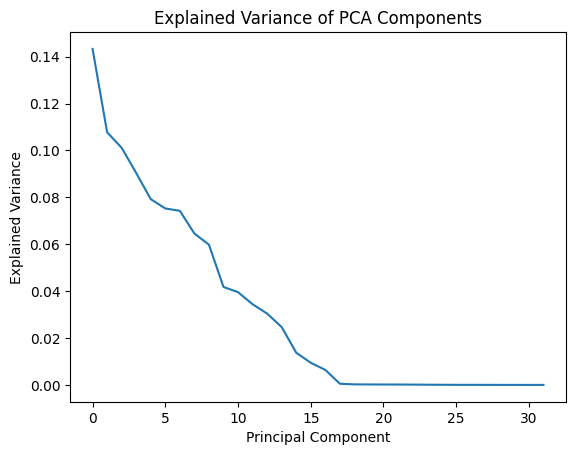

In [17]:
pca = PCA(n_components=384)
pca.fit(tx)
fig, ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_[0:32])
ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance")
ax.set_title("Explained Variance of PCA Components")

## CLUSTERING METRICS

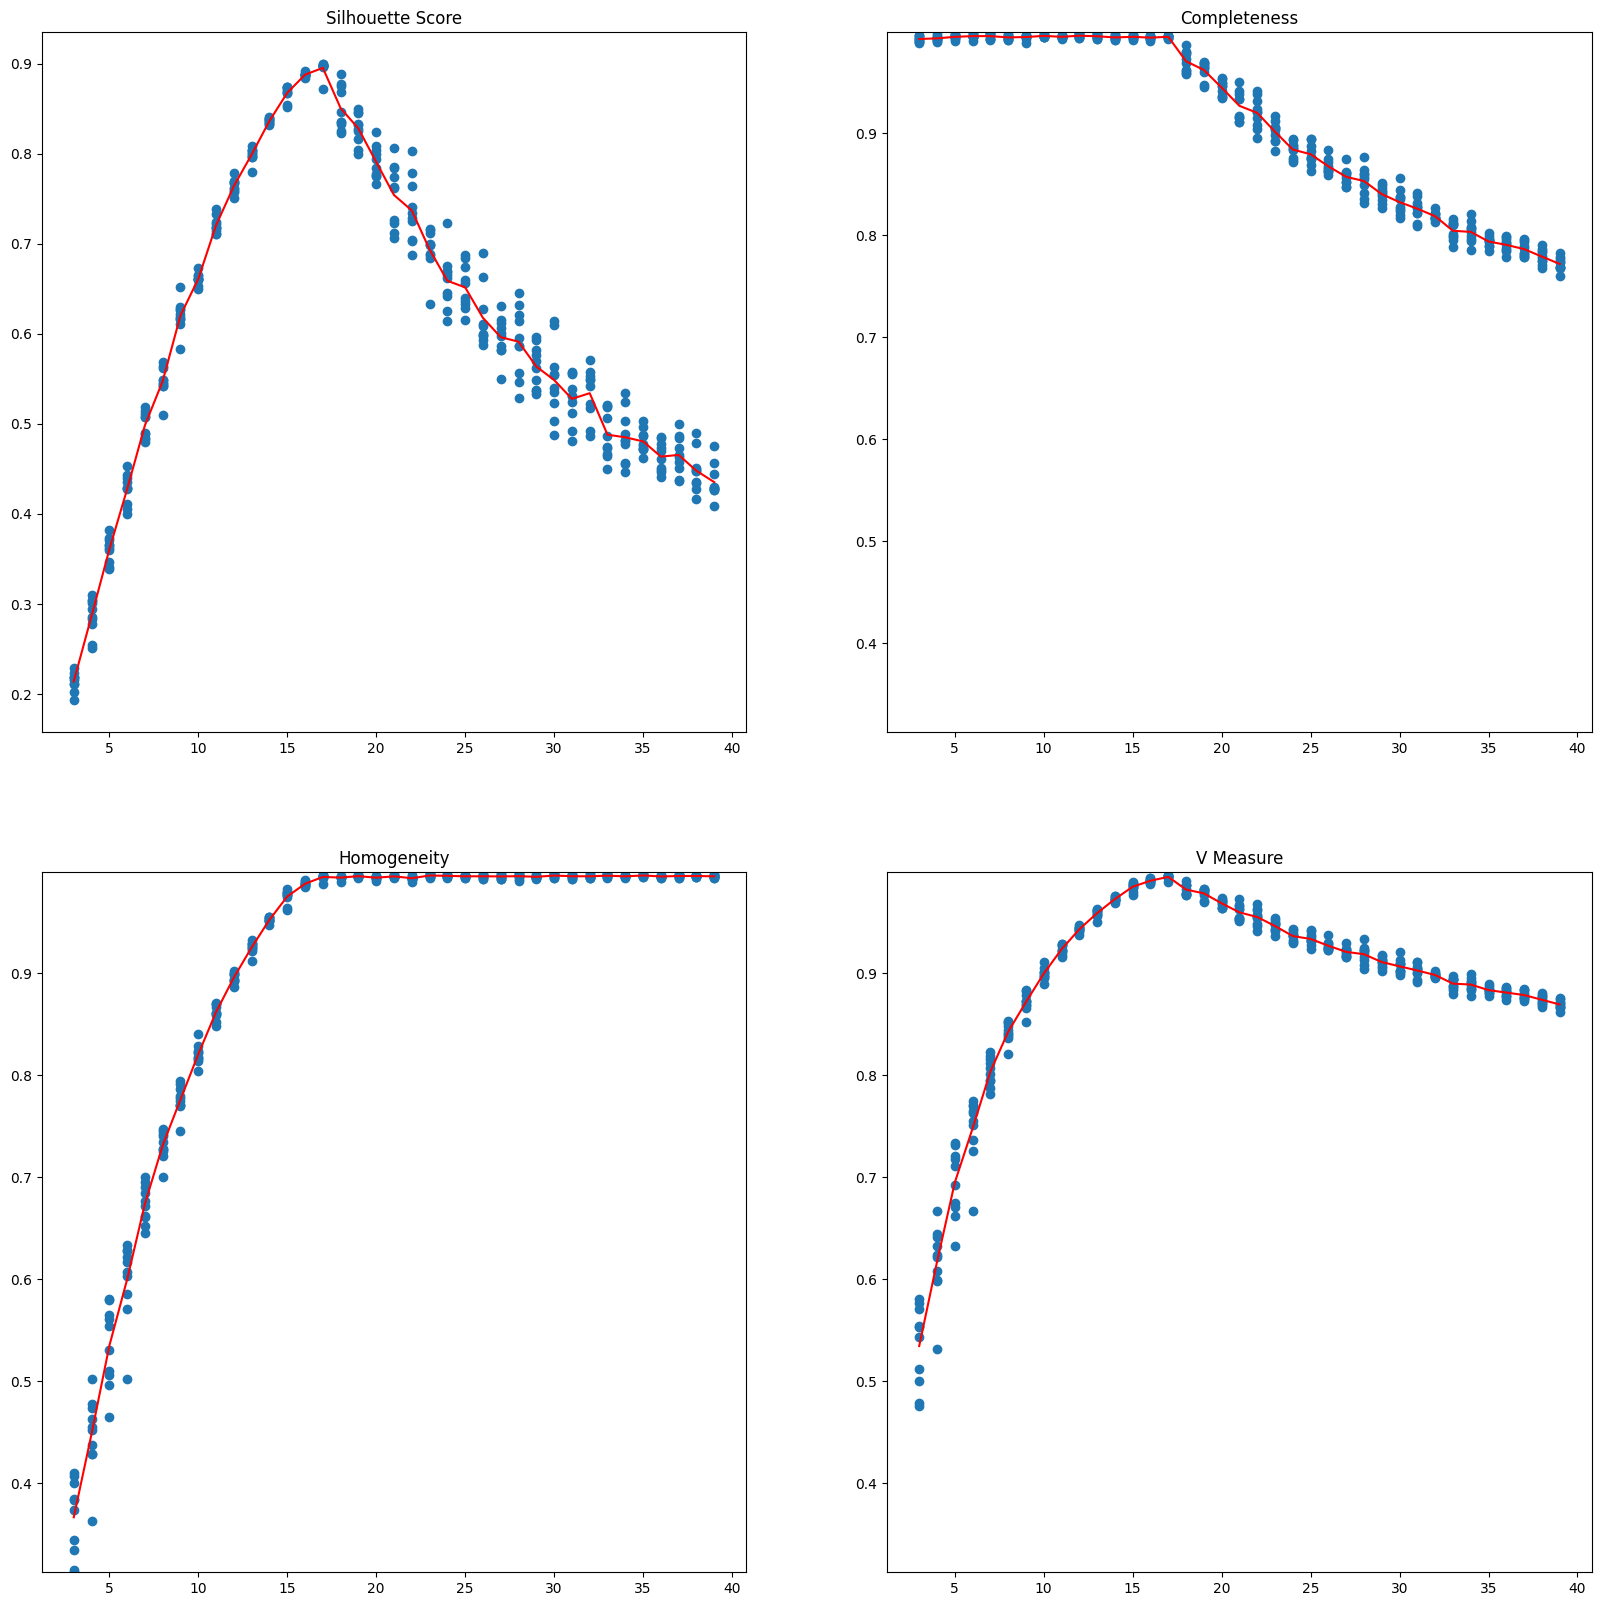

In [18]:
xh = tx
fy = ty
obs = []
for k in range(3, 40, 1):
    for i in range(10):
        km = KMeans(n_clusters=k, random_state=random.randint(0, 1000), n_init='auto')
        inds = np.random.choice(xh.shape[0], 5000)
        sxh = xh[inds, :]
        km.fit(sxh)
        yh = km.predict(sxh)
        obs.append([k, silhouette_score(sxh, yh), *homogeneity_completeness_v_measure(fy[inds], yh)])
    print(k, end = '\r')
df = pd.DataFrame(obs, columns = ['k', 'sil', 'h', 'c', 'v'])
mv = df.groupby('k').mean()


fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs[0, 0].scatter(df['k'], df['sil'])
axs[0, 0].set_title('Silhouette Score')
axs[0, 0].plot(mv.index , mv['sil'], color = 'red')

ymin = df[['h', 'c', 'v']].min().min()
ymax = df[['h', 'c', 'v']].max().max()

axs[1, 0].scatter(df['k'], df['h'])
axs[1, 0].set_title('Homogeneity')
axs[1, 0].set_ylim(ymin, ymax)
axs[1, 0].plot(mv.index , mv['h'], color = 'red')

axs[0, 1].scatter(df['k'], df['c'])
axs[0, 1].set_title('Completeness')
axs[0, 1].set_ylim(ymin, ymax)
axs[0, 1].plot(mv.index , mv['c'], color = 'red')

axs[1, 1].scatter(df['k'], df['v'])
axs[1, 1].set_title('V Measure')
axs[1, 1].set_ylim(ymin, ymax)
axs[1, 1].plot(mv.index , mv['v'], color = 'red')

## KNN CLASSIFIER ACCURACY

In [19]:
knn_ld_km = KNeighborsClassifier(**KNN_CLASSIFIER_ARGS)
knn_ld_km.fit(kmccx, lyh)
knn_ld_km.score(TX[:, :TRUNCATION], TY)

0.99750316500211

## KNN WRONG TEMPLATES

In [20]:
py = knn_ld_km.predict(TX[:, :TRUNCATION])
pyl = le.inverse_transform(py)
Markdown(pd.DataFrame(list(zip(np.asarray(TqX)[TY != py], pyl[TY != py])), columns = ["Question", "Predicted Category"]).to_markdown())

|     | Question                                                                                                                                           | Predicted Category   |
|----:|:---------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------|
|   0 | Mexican entities whose rating changed in 1992                                                                                                      | rating_action        |
|   1 | Debt Levels in australia                                                                                                                           | financials           |
|   2 | Generate a list an Economic Imbalances on the tech industry?                                                                                       | general              |
|   3 | what is the Period Ended for Alaska Airlines in fiscal 2017 & 2024?                                                                                | general              |
|   4 | What is Inventory Turnover of passenger airlines?                                                                                                  | general              |
|   5 | how does the Tariffs and trade wars impact sovereign sector ratings?                                                                               | criteria             |
|   6 | What are A Ratings                                                                                                                                 | definition           |
|   7 | Show me all an Funding & Liquidity on the tech industry?                                                                                           | query                |
|   8 | Top 5 of an Economic Risk on the tech industry?                                                                                                    | general              |
|   9 | Could you give me a credit memo for NVIDIA Corporation?                                                                                            | credit_memo          |
|  10 | Credit Ratings in South Korea                                                                                                                      | ratings              |
|  11 | Show me Net Property, Plant & Equipment of retail reoc?                                                                                            | financials           |
|  12 | how does the Currency devaluation impact Structured Finance sector Ratings?                                                                        | criteria             |
|  13 | Provide me the Group Support the United States                                                                                                     | general              |
|  14 | What are the port authority of greater cincinnati development authority, ohio's latest GDP growth?                                                 | info_coverage        |
|  15 | American entities whose rating changed in 2022                                                                                                     | query                |
|  16 | Top 10 of a credit memo for Alaska Airlines?                                                                                                       | credit_memo          |
|  17 | Provide the port authority of greater cincinnati development authority, ohio Economic Imbalances                                                   | financials           |
|  18 | What is the average exchange rate for Federal Home Loan Banks                                                                                      | general              |
|  19 | What were the credit rating actions that were given in January of 2025?                                                                            | rating_action        |
|  20 | What is CCC- Ratings                                                                                                                               | definition           |
|  21 | Indian entities whose rating changed in 2026                                                                                                       | rating_action        |
|  22 | Chinese entities whose rating changed in 2011                                                                                                      | rating_action        |
|  23 | Show me Diluted EPS Incl. Extra Items of carbon bisulfide?                                                                                         | financials           |
|  24 | Canadian entities whose rating changed in 2017                                                                                                     | rating_action        |
|  25 | Top 5 of a credit memo for adrian independent school district, tx permanent school fund program?                                                   | credit_memo          |
|  26 | Can you generate a credit memo for Barry Cnty R-IV Sch Dist (Cassville)?                                                                           | credit_memo          |
|  27 | What are Net Property, Plant & Equipment for credit risk software?                                                                                 | general              |
|  28 | Give me a list of a list of companies that have a positive outlook in the coming years?                                                            | query                |
|  29 | What is the credit ratings in USA?                                                                                                                 | ratings              |
|  30 | Show me the ALAC Support of Barry Cnty R-IV Sch Dist (Cassville), MO Direct Deposit State Aid Program?                                             | info_coverage        |
|  31 | What are greece's latest foreign exchange volatility?                                                                                              | financials           |
|  32 | What is the Period Ended for Maybank Philippines                                                                                                   | info_coverage        |
|  33 | What is the Government Fiscal Policy in turkey?                                                                                                    | scores&modifiers     |
|  34 | What were the credit rating actions that were given in January of 2017?                                                                            | rating_action        |
|  35 | Is net debt to Banque de Tunisie et des Emirats Société anonyme more popular than gross debt to Banque de Tunisie et des Emirats Société anonyme?  | general              |
|  36 | what were the Banque de Tunisie et des Emirats Société anonyme for mo direct deposit state aid program in Q1, Q2 and Q3 of 2026                    | general              |
|  37 | Japanese entities whose rating changed in 2025                                                                                                     | rating_action        |
|  38 | American entities whose rating changed in 2023                                                                                                     | rating_action        |
|  39 | Provide me the business risk Yale Univ CT General Obligation                                                                                       | general              |
|  40 | What is the current financial health or status of the Yoakum Indpt Sch Dist, TX Permanent School Fund Program                                      | scores&modifiers     |
|  41 | What is the Business Position for city of ancona?                                                                                                  | info_coverage        |
|  42 | Tell me about Japan's risk exposure                                                                                                                | general              |
|  43 | Are there any secondary smelting and refining of aluminum entities that have a positive outlook?                                                   | general              |
|  44 | Show me all five categories of group status issuers within EMEA                                                                                    | general              |
|  45 | What are Aetna Inc's latest consumer confidence?                                                                                                   | scores&modifiers     |
|  46 | Generate a list a company review on Greenville, TX Limited Tax General Operating Pledge and Water and Sewer System Subordinate Lien?               | query                |
|  47 | What are yale univ ct general obligation's latest foreign exchange volatility?                                                                     | financials           |
|  48 | Generate a list an Indicative Rating on the tech industry?                                                                                         | general              |
|  49 | What are the key Business Position associated with arvada, co lease appropriation?                                                                 | info_coverage        |
|  50 | What is the Net Property, Plant & Equipment for Imperial Brands PLC?                                                                               | financials           |
|  51 | What is Change in Net Working Capital for wood box spring frames?                                                                                  | general              |
|  52 | How does an analyst use the Industry Risk Score for Domiciled Country?                                                                             | scores&modifiers     |
|  53 | Give me a list an Anchor on the tech industry?                                                                                                     | general              |
|  54 | what is the Equity Interests or Participations (Nonfinancial) for samsung electronics in fiscal 1986 & 2027?                                       | general              |
|  55 | credit ratings amount in India                                                                                                                     | query                |
|  56 | What is information on CC Ratings?                                                                                                                 | general              |
|  57 | What is the credit ratings in Brazil?                                                                                                              | ratings              |
|  58 | Spanish entities whose rating changed in 2023                                                                                                      | rating_action        |
|  59 | North American Industry Classification System Code of iraq reinsurance company?                                                                    | general              |
|  60 | How did the 21st Century Fox acquisition impact Disney's Credit Risk?                                                                              | scores&modifiers     |
|  61 | Can you provide a credit risk analysis for the Artificial Intelligence?                                                                            | scores&modifiers     |
|  62 | What is the current financial health or status of the Barry Cnty R-IV Sch Dist (Cassville)                                                         | scores&modifiers     |
|  63 | S&P global ratings country of Alaska Airlines?                                                                                                     | general              |
|  64 | Retail sector in S. Korea.                                                                                                                         | info_coverage        |
|  65 | Japanese entities whose rating changed in 2027                                                                                                     | rating_action        |
|  66 | What are Arvada, CO Lease Appropriation's Sales Growth Rate and Debt Service Coverage Ratio (DSCR).                                                | scores&modifiers     |
|  67 | Canadian entities whose rating changed in 2025                                                                                                     | query                |
|  68 | Can you provide a summary or updates about Merrill Lynch International and PMI CDS (Cayman) IV Ltd?                                                | scores&modifiers     |
|  69 | S&P global ratings country of Japan and 3m company?                                                                                                | general              |
|  70 | Give me a list of an Liquidity on the tech industry?                                                                                               | general              |
|  71 | Mexican entities whose rating changed in 2026                                                                                                      | rating_action        |
|  72 | What are the key business risks for Aerospace Sector?                                                                                              | query                |
|  73 | list of current ratio of motor vehicle gauges?                                                                                                     | general              |
|  74 | Provide (ENXTPA:ARG) Argan SA capital & earnings                                                                                                   | financials           |
|  75 | Japanese entities whose rating changed in 2022                                                                                                     | rating_action        |
|  76 | Bhutanese entities whose rating changed in 1986                                                                                                    | rating_action        |
|  77 | can you compare Triple Enhanced Rated Notes (TERN) Ltd.'s general fund balance position to other Connecticut municipal issuers?                    | financials           |
|  78 | Spanish entities whose rating changed in 2011                                                                                                      | rating_action        |
|  79 | Give me a list the business and sovereign credit rating agencies and Country Risk Assessment                                                       | query                |
|  80 | What is a credit memo for Grafton Group plc?                                                                                                       | credit_memo          |
|  81 | now how about the variety stores in India?                                                                                                         | query                |
|  82 | can you prepare a credit memo for Yale Univ CT General Obligation?                                                                                 | credit_memo          |
|  83 | Indian entities whose rating changed in 2022                                                                                                       | rating_action        |
|  84 | What is earnings before interest, taxes, depreciation, and amortization of bridge, tunnel, and elevated highway construction?                      | financials           |
|  85 | Provide me the ALAC Support Banco ABC Brasil S.A                                                                                                   | info_coverage        |
|  86 | Provide me Period Ended for mo direct deposit state aid program                                                                                    | general              |
|  87 | Any rating actions due to currency volatility, or a movements in currencies and foreign exchange?                                                  | general              |
|  88 | Can you provide an overview of Barry Cnty R-IV Sch Dist (Cassville) and egypt?                                                                     | info_coverage        |
|  89 | Can you show me a credit memo for BNP Paribas?                                                                                                     | credit_memo          |
|  90 | can you prepare an funding & liquidity on the tech industry?                                                                                       | general              |
|  91 | now how about the mufflers in Saudi Arabia?                                                                                                        | scores&modifiers     |
|  92 | Generate a list an Anchor on the tech industry?                                                                                                    | general              |
|  93 | Provide me the business position Yale Univ CT General Obligation                                                                                   | general              |
|  94 | What are Ravago S.A.'s Total Debt, Average Days Sales Out., and Debt Service Coverage Ratio (DSCR)                                                 | scores&modifiers     |
|  95 | What are the operating system software and Country Risk Assessment                                                                                 | query                |
|  96 | What is the 2027 year end barry cnty r-iv sch dist (cassville), mo direct deposit state aid program, according to the PCAF standard?               | scores&modifiers     |
|  97 | What is AA Ratings                                                                                                                                 | definition           |
|  98 | What are NVIDIA Corporation's latest foreign exchange volatility?                                                                                  | financials           |
|  99 | What is sovereign constraints issuers within Pacific                                                                                               | general              |
| 100 | American entities whose rating changed in 2026                                                                                                     | query                |
| 101 | Indian entities whose rating changed in 2025                                                                                                       | rating_action        |
| 102 | Canadian entities whose rating changed in 2024                                                                                                     | query                |
| 103 | American entities whose rating changed in 2024                                                                                                     | query                |
| 104 | What is the Capital Expenditure for Ravago S.A.                                                                                                    | scores&modifiers     |
| 105 | Canadian entities whose rating changed in 2027                                                                                                     | query                |
| 106 | Show me a list of corporate sector ratings with BBB- ratings in Saudi Arabia                                                                       | general              |
| 107 | Could you give me a credit memo for Yoakum Indpt Sch Dist, TX Permanent School Fund Program?                                                       | credit_memo          |
| 108 | now how about the amplifiers in turkey?                                                                                                            | scores&modifiers     |
| 109 | What is the current financial health or status of the yoakum indpt sch dist, tx permanent school fund program                                      | scores&modifiers     |
| 110 | What are Change in Net Working Capital for Credit Risk Software?                                                                                   | general              |
| 111 | Japanese entities whose rating changed in 2011                                                                                                     | rating_action        |
| 112 | S&P global ratings sector of Iraq Reinsurance Company?                                                                                             | general              |
| 113 | Show me yoakum indpt sch dist, tx permanent school fund program's Period Ended                                                                     | general              |
| 114 | What is the outlook for the EV companies                                                                                                           | general              |
| 115 | Can you show me Diluted Earnings Per Share Excluding Extra Items for boys' trousers, slacks and shorts?                                            | financials           |
| 116 | Provide me Banque de Tunisie et des Emirats Société anonyme for Samsung                                                                            | info_coverage        |
| 117 | Can you provide the Role for Brazil and Japan?                                                                                                     | general              |
| 118 | What are information on BB Ratings?                                                                                                                | general              |
| 119 | S&P Ratings Country / Region of mo direct deposit state aid program?                                                                               | financials           |
| 120 | What is the outlook for the holding companies, patent owners, and trusts or estates in EMEA in 2011?                                               | scores&modifiers     |
| 121 | Can you generate earnings from continuing operations margin of investment funds?                                                                   | criteria             |
| 122 | list of a credit memo for Barry Cnty R-IV Sch Dist (Cassville)?                                                                                    | credit_memo          |
| 123 | Can you provide the Banque de Tunisie et des Emirats Société anonyme and Total Common Equity of Souza Cruz                                         | info_coverage        |
| 124 | What is the Credit Ratings for the electronic components in Japan?                                                                                 | ratings              |
| 125 | Generate a list of an Anchor on the tech industry?                                                                                                 | general              |
| 126 | credit ratings in Argentina                                                                                                                        | ratings              |
| 127 | list of an diversification/portfolio effect on the tech industry?                                                                                  | general              |
| 128 | Russian entities whose rating changed in 2022                                                                                                      | rating_action        |
| 129 | Bhutanese entities whose rating changed in 2008                                                                                                    | rating_action        |
| 130 | American entities whose rating changed in 1992                                                                                                     | query                |
| 131 | What is cash flow/leverage for EVIC for Essar Oil (UK) Limited                                                                                     | financials           |
| 132 | Mexican entities whose rating changed in 1986                                                                                                      | rating_action        |
| 133 | Top 5 of a credit memo for fifth third bank of indiana?                                                                                            | credit_memo          |
| 134 | What is the credit ratings in south korea?                                                                                                         | ratings              |
| 135 | S&P global ratings subsector of Chevron?                                                                                                           | financials           |
| 136 | Show me a report about the financial structure of Greenville, TX Limited Tax General Operating Pledge and Water and Sewer System Subordinate Lien? | scores&modifiers     |
| 137 | Name an Sovereign Constraint on the tech industry?                                                                                                 | general              |
| 138 | Are there any intercity and rural bus transportation entities that have a positive outlook?                                                        | outlook              |
| 139 | Corporate Earnings amount in Spain                                                                                                                 | financials           |
| 140 | what is the Debt Service Coverage Ratio (DSCR) for Seven Bank, Ltd in fiscal 2008 & 2019?                                                          | scores&modifiers     |
| 141 | Show me the Business Position of EVIC for Essar Oil (UK) Limited?                                                                                  | info_coverage        |
| 142 | What are the port authority of greater cincinnati development authority, ohio's ALAC Support?                                                      | info_coverage        |
| 143 | Show me all a list of companies that have a positive outlook in the coming years?                                                                  | query                |
| 144 | What is the Average Exchange Rate for Volkswagen                                                                                                   | scores&modifiers     |
| 145 | What is the total revenue outlook and earnings outlook for men's underwear and pajamas?                                                            | financials           |
| 146 | Can you generate a credit memo for Associated British Foods?                                                                                       | credit_memo          |
| 147 | Chinese entities whose rating changed in 2022                                                                                                      | rating_action        |
| 148 | Top 5 of an Comparable Rating Adjustment on the tech industry?                                                                                     | query                |
| 149 | Generate a list of an Sovereign Constraint on the tech industry?                                                                                   | general              |
| 150 | Name Diluted EPS Excl. Extra Items of laboratory apparatus?                                                                                        | general              |
| 151 | What are Grafton Group plc's Adjustment Status & Currency Code, total debt/equity, and Debt Service Coverage Ratio (DSCR)                          | scores&modifiers     |
| 152 | Can you provide an overview of EVIC for Essar Oil (UK) Limited and Honeywell International Inc.?                                                   | info_coverage        |
| 153 | What are the Business Position associated with the The Port Authority of Greater Cincinnati Development Authority, Ohio?                           | info_coverage        |
| 154 | Can you generate Spot Exchange Rate for pearls?                                                                                                    | general              |
| 155 | Show me a credit memo for minnesota life insurance co.?                                                                                            | credit_memo          |
| 156 | Chinese entities whose rating changed in 1986                                                                                                      | rating_action        |
| 157 | Top 10 of a credit memo for Oracle Corporation?                                                                                                    | credit_memo          |
| 158 | Debt Levels amount in mexico                                                                                                                       | financials           |
| 159 | What is sovereign constraints issuers within EMEA                                                                                                  | general              |
| 160 | how does the Cybersecurity breaches impact Structured Finance sector Ratings?                                                                      | criteria             |
| 161 | Canadian entities whose rating changed in 2005                                                                                                     | rating_action        |
| 162 | Mexican entities whose rating changed in 2024                                                                                                      | rating_action        |
| 163 | Give me a list five categories of group status issuers within Pacific                                                                              | general              |
| 164 | Show me EVIC for Essar Oil (UK) Limited's Total Common Equity                                                                                      | general              |
| 165 | Credit Ratings in australia                                                                                                                        | ratings              |
| 166 | What are Meta (Facebook)'s Cash flow?                                                                                                              | financials           |
| 167 | Can you provide quick ratio for computer telephone integration (cti) software?                                                                     | general              |
| 168 | Generate a list of an Comparable Ratings Analysis on the tech industry?                                                                            | general              |
| 169 | Identify rayon fibers with a negative outlook.                                                                                                     | general              |
| 170 | Spanish entities whose rating changed in 2005                                                                                                      | rating_action        |
| 171 | What is the Total Debt / Total Capital outlook and earnings outlook for environment, conservation, and wildlife organizations?                     | query                |
| 172 | Can you generate average accounts receivable turnover for Aerospace Sector?                                                                        | general              |
| 173 | What is the Credit Ratings for the automation products and services in United Kingdom?                                                             | ratings              |
| 174 | Tell me about (ENXTPA:ARG) Argan SA's ALAC Support?                                                                                                | general              |
| 175 | what is the Period Ended for Spirit Airlines in fiscal 2022 & 2024?                                                                                | general              |
| 176 | Generate a list of an Cash flow on the tech industry?                                                                                              | general              |
| 177 | Provide me the Business Position Aegean Baltic Bank A.E                                                                                            | info_coverage        |
| 178 | What are the Comparable Rating Adjustment for the United States?                                                                                   | query                |
| 179 | What is the return on assets for Imperial Brands PLC?                                                                                              | financials           |
| 180 | Can you provide the samsung period ended data for 2027 and 2027 broken down by quarter?                                                            | general              |
| 181 | Russian entities whose rating changed in 2025                                                                                                      | rating_action        |
| 182 | NACE of yale univ ct general obligation?                                                                                                           | general              |
| 183 | What is the Banque de Tunisie et des Emirats Société anonyme for Imperial Brands PLC?                                                              | info_coverage        |
| 184 | How can I assess an data processing and outsourced services for insurance industry?                                                                | general              |
| 185 | S&P global ratings subsector of greece?                                                                                                            | general              |
| 186 | Indian entities whose rating changed in 2005                                                                                                       | query                |
| 187 | Show me EBIT Margin of gypsum?                                                                                                                     | financials           |
| 188 | can you prepare an financial policy on the tech industry?                                                                                          | general              |
| 189 | What are a list of companies that have a positive outlook in the coming years?                                                                     | query                |
| 190 | What were the credit rating actions that were given in January of 2023?                                                                            | rating_action        |
| 191 | Chinese entities whose rating changed in 2005                                                                                                      | query                |
| 192 | what are the main factors that influence the Outlook of Oracle Corporation                                                                         | outlook              |
| 193 | American entities whose rating changed in 1986                                                                                                     | rating_action        |
| 194 | What are earnings from continuing operations for electrical repair?                                                                                | general              |
| 195 | Show me Amneal Pharmaceutical Debt Service Coverage Ratio (DSCR) data for 2027 and 2022 divided by quarters.                                       | scores&modifiers     |
| 196 | what is SPUR                                                                                                                                       | general              |
| 197 | Show me all an diversification/portfolio effect on the tech industry?                                                                              | general              |
| 198 | Bhutanese entities whose rating changed in 1992                                                                                                    | rating_action        |
| 199 | Provide me the industry risk Johnson Arabia LLC                                                                                                    | general              |
| 200 | Give me a list current ratio of telecom tower reit?                                                                                                | general              |
| 201 | What is CCC Ratings                                                                                                                                | definition           |
| 202 | Which industry does the United States belog?                                                                                                       | general              |
| 203 | Top 5 of an Sovereign Constraint on the tech industry?                                                                                             | general              |
| 204 | what is the Cash Conversion Cycle for ibm in fiscal 2027 & 2026?                                                                                   | scores&modifiers     |
| 205 | What is the CARG in russia?                                                                                                                        | info_coverage        |
| 206 | Name an business risk on the tech industry?                                                                                                        | general              |
| 207 | What is the Total Assets outlook and earnings outlook for drug and alcohol screening services?                                                     | outlook              |
| 208 | What is Earnings from Cont Ops Margin of clays?                                                                                                    | financials           |
| 209 | What are the main factors that influence the Outlook of Secure Waste Infrastructure Corp?                                                          | outlook              |
| 210 | Can you show me Total Debt/Equity for corn?                                                                                                        | general              |
| 211 | What is the GDP in the United States?                                                                                                              | financials           |
| 212 | What is the Credit Ratings in australia?                                                                                                           | ratings              |

## CENTROID MODE MAJORITY PERCENTAGE

In [21]:
np.mean([np.mean(lyh[k] == ty[kyh == k]) for k in range(kmccx.shape[0])])

0.9492033552570601

In [22]:
np.min([np.mean(lyh[k] == ty[kyh == k]) for k in range(kmccx.shape[0])])

0.2857142857142857

In [23]:
RUN_ID

'ROUTING_CRITERIA_UC_TYPE2__2025-11-03'

In [24]:
!cp -r "/home/sagemaker-user/creditcompanion/scripts/uc_embedding_generation/notebooks/models/adapters/{RUN_ID}"  /home/sagemaker-user/crs-gen-ai-aws-infra/30-chatrd/assets/router/adapters
!cp -r "/home/sagemaker-user/creditcompanion/scripts/uc_embedding_generation/notebooks/models/classifiers/{RUN_ID}"  /home/sagemaker-user/crs-gen-ai-aws-infra/30-chatrd/assets/router/classifiers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [25]:
RUN_ID

'ROUTING_CRITERIA_UC_TYPE2__2025-11-03'

In [26]:
!cp -r "/home/sagemaker-user/creditcompanion/scripts/uc_embedding_generation/notebooks/models/adapters/{RUN_ID}"  /home/sagemaker-user/routing/rvs-ds-cc-routing-endpoint/s3_bucket/adapters
!cp -r "/home/sagemaker-user/creditcompanion/scripts/uc_embedding_generation/notebooks/models/classifiers/{RUN_ID}"  /home/sagemaker-user/routing/rvs-ds-cc-routing-endpoint/s3_bucket/classifiers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [27]:
!dir  /home/sagemaker-user/routing/rvs-ds-cc-routing-endpoint/s3_bucket/adapters

ROUTING_0806__2025-08-11	       ROUTING_CRITERIA_UC_TYPE_2025-10-31
ROUTING_09_19_2025-09-19	       ROUTING_CRITERIA_UC_TYPE_2025-11-03
ROUTING_22_08__2025-08-22	       ROUTING_GENERAL_UC_TYPE_2025-10-28
ROUTING_BUGS_2025-06-20		       ROUTING_improvement_2025-10-13
ROUTING_CRITERIA_UC_TYPE2__2025-11-03  bone_3
ROUTING_CRITERIA_UC_TYPE_2025-10-30


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
